# RC Project

Emanuele Gentiletti, AA 2021/2022

## Introduction

For this exercise, I picked the ego-Facebook dataset (http://snap.stanford.edu/data/ego-Facebook.html), which represents the combined friend list of 10 different Facebook users. The dataset also contains some anonymized features for each user (ex. date of birth, location), which will be used to see if there's any relation between the structural properties of the graph and the users' data. Since the data is combined from ten different users, it will be also interesting to see if there is potentially a relation between the data's sources and the graph structure, like in connected components and communities.

### Imports and settings

In [3]:
from functools import cached_property
import random
import sys
from dataclasses import dataclass
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd

from networkx.algorithms.community.louvain import louvain_communities
from networkx.algorithms.community.quality import modularity

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, MultipleLocator, MaxNLocator

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    pass

pd.options.display.float_format = '{:,.4f}'.format

def seed(seed=None):
    """
    Seeds the RNG and prints the seed used.
    """
    seed = seed or random.randrange(sys.maxsize)
    random.seed(seed)
    print(f"Seed: {seed}")

Loading the graph into memory.

In [4]:
def load_graph() -> nx.Graph:
    data = pd.read_table('data/facebook_combined.txt', sep=' ')
    return nx.from_pandas_edgelist(data, source='0', target='1')


G = load_graph()

## Network Metrics

### Graph size

To get some preliminary basic info, the graph is small/medium sized, with 4039 nodes and 88233 edges. There is only one connected component in the network.

In [5]:
len(G.nodes)

4039

In [6]:
len(G.edges)

88233

In [7]:
nx.number_connected_components(G)

1

### Node degree and degree distribution

The network has nodes with varying degrees of connectivity. Looking at the degree distribution, the standard deviation is approximately 52, suggesting a wide range of degrees, possibly indicating the presence of hubs alongside nodes with lower connectivity. The presence of nodes with low degrees might indicate isolated nodes or nodes with limited interactions, and at least one node has just one neighbor. It's also interesting to note that 75% of the nodes have degree 57 or less.
Also, the maximum degree is 1045, which belongs to a hub that is singlehandedly connected to one fourth of the network.

In [8]:
degrees = pd.Series(dict(G.degree))
degrees.describe()

count   4,039.0000
mean       43.6905
std        52.4193
min         1.0000
25%        11.0000
50%        25.0000
75%        57.0000
max     1,045.0000
dtype: float64

Visualizing the network distribution, it becomes clear that the vast majority of nodes have degrees that range around 1 and 200, with few very connected nodes above those. Looking at the ten nodes with the largest degrees, it can be seen how stark the drop is from the degree value of 1045 to 235. This shows how the network has a handful of extremely connected hubs to pump up its average degree. This can be observed also in the difference between the degrees average and median value: the average degree is 43, but 50% of the nodes have a degree that doesn't go above 25.

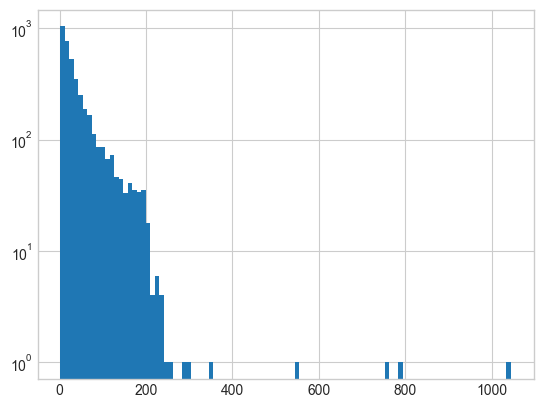

In [9]:
degrees.hist(bins=100, log=True);

In [10]:
degrees.nlargest(10)

107     1045
1684     792
1912     755
3437     547
0        346
2543     294
2347     291
1888     254
1800     245
1663     235
dtype: int64

There are also observations that can follow by seeing the degree assortativity coefficient. The coefficient is positive, suggesting a core-periphery structure where high-degree nodes tend to stick to each other.

In [11]:
nx.degree_assortativity_coefficient(G)

0.06362720216682463

### Distance ditribution

In [12]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

Observing the distribution of the longest shortest path, they range between 5 and 8, with the majority being 6 and the diameter being 8. The paths are overall very short, and the network exhibits the small world property, in line with the fact that there are very big and connected hubs, and that we're observing a social network, which tends to follow this behavior.

In [13]:
longest_shortest_paths = pd.Series(
    dict(
        (source, max(path_lengths.values()))
        for source, path_lengths in shortest_paths.items()
    )
)

longest_shortest_paths.describe()

count   4,039.0000
mean        6.3555
std         0.6166
min         5.0000
25%         6.0000
50%         6.0000
75%         7.0000
max         8.0000
dtype: float64

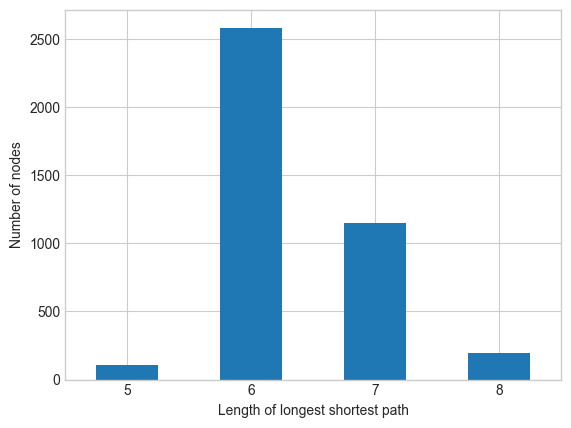

In [14]:
longest_shortest_paths.value_counts(sort=False).sort_index().plot.bar()
plt.xlabel("Length of longest shortest path")
plt.ylabel("Number of nodes")
plt.xticks(rotation=0);

### Betweenness

Looking at the betweenness, the values seems generally very low. This suggests that the majority of nodes are not frequently positioned on the shortest paths between other nodes. This can be an indication of the reliance of the network on hubs to allow for efficient connectivity and short paths. The majority of the nodes aren't the most efficient way to reach someone else. This is in line with the fact that there is a giant hub that has contacts with one fourth of the network, and we can see that its value is almost .5, which means that almost half of all shortest paths between a node to another are reliant on this node. Looking at the ten biggest betweennesses, it can be shown there is a fast drop, similarly to how it happened with the degree.

In [15]:
betweenness = pd.Series(nx.betweenness_centrality(G))
betweenness.describe()

count   4,039.0000
mean        0.0007
std         0.0116
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         0.4805
dtype: float64

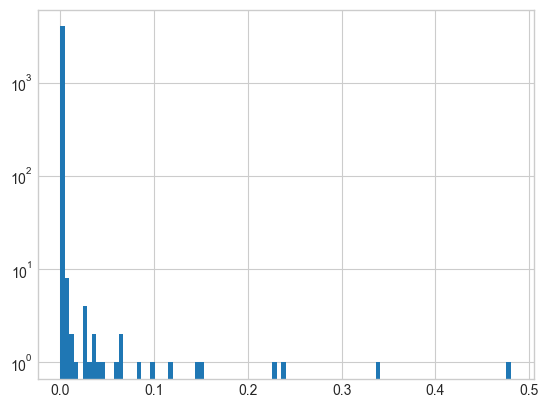

In [16]:
betweenness.hist(bins=100, log=True);

In [17]:
betweenness.nlargest(10)

107    0.4805
1684   0.3378
3437   0.2361
1912   0.2293
1085   0.1490
0      0.1461
698    0.1153
567    0.0963
58     0.0843
428    0.0643
dtype: float64

### Clustering Coefficients

The network has an high average clustering coefficient. This is consistent with the network being a social network, where the triadic closure tends to act strongly. There is a decent amount of variability in it, which is accordance with the disparity previously observed in degree and centrality between the nodes. It makes sense that the more peripheral nodes might tend to have less triangles closed, due to their lower general connectivity. There are more or less 75 nodes that don't have neighbors that form triangles.

In [18]:
ccs = pd.Series(nx.clustering(G))
ccs.describe()

count   4,039.0000
mean        0.6055
std         0.2145
min         0.0000
25%         0.4667
50%         0.6000
75%         0.7524
max         1.0000
dtype: float64

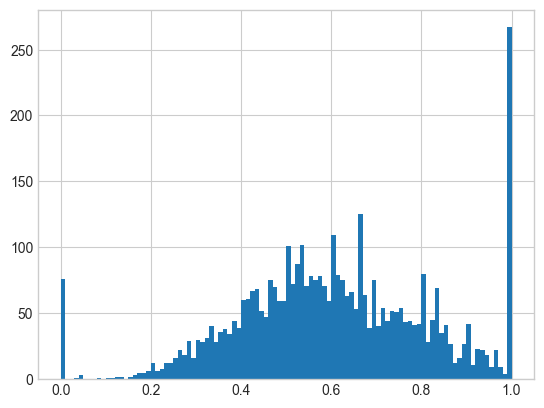

In [19]:
ccs.hist(bins=100);

## Community detection

For the community detection part of the exercise, at first there will be a rough estimation for an appropriate amount of clusters in the network, using the isolated eigenvalues method. After this, clustering will be performed comparing the following algorithms:

- spectral clustering
- modularity optimization with the Louvain algorithm
- KMeans over the feature vectors

Since the Louvain algorithm estimates its own number of communities, to make the comparison of their respective NMI scores meaningful, the clustering is performed again for the other algorithms with the Louvain chosen number of clusters.

### Estimating the number of communities.

After computing the eigenvalues of the Laplacian matrix and getting some statistics about them, we look for the ones that seem more spread out with respect to the bulk of them.

In [20]:
L = nx.laplacian_matrix(G).toarray()
eigvals, eigvecs = np.linalg.eigh(L)
eigvals = pd.Series(eigvals)
eigvals.describe()

count   4,039.0000
mean       43.6905
std        52.8345
min         0.0000
25%        10.6877
50%        25.0021
75%        57.8047
max     1,046.0052
dtype: float64

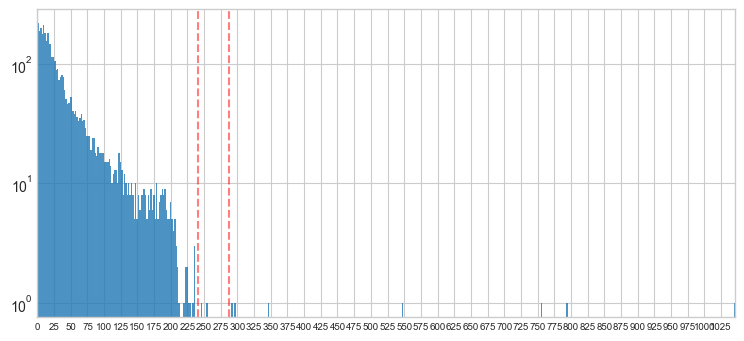

In [21]:
eigvals.hist(bins=500, log=True, alpha=0.8, figsize=(9, 4), xlabelsize=7)
plt.xlim(left=0, right=max(eigvals))
plt.axvline(x = eigvals[eigvals>240].iloc[0] - 5, color = 'red', linestyle = '--', alpha = 0.5)
plt.axvline(x = eigvals[eigvals>275].iloc[0] - 5, color = 'red', linestyle = '--', alpha = 0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))

From the histogram, it can be seen that the bulk of the eigenvalues have value 200 or lower.
Somewhere between 225 and 250 there are some values that start being more isolated with respect to the others, but after the 275 mark those distances start being a lot more marked. I've drawn two dashed lines on the histogram, which represent possible demarcation points between the bulk and isolated eigenvalues: one separates eigenvalues bigger than 240, and the other the values bigger than 275.

It is also interesting to observe the similarity with the degree distribution plot.

In [22]:
eigvals[eigvals > 220]

4019     221.1802
4020     221.9968
4021     223.0477
4022     224.8492
4023     225.5255
4024     227.1903
4025     229.8228
4026     232.3172
4027     235.0824
4028     235.1282
4029     236.1421
4030     246.0993
4031     255.0674
4032     292.1579
4033     295.2087
4034     346.9976
4035     548.0006
4036     756.0006
4037     792.9953
4038   1,046.0052
dtype: float64

Between the eigenvalue 4029 and 4030 the difference starts to be in the 10s, and
moving forward it gets more and more pronounced. 
For this exercise, the eigenvalues bigger than 246 are designated as isolated
eigenvalues, giving an approximation of 9 clusters.

### Spectral clustering

The spectral clustering algorithm is implemented by receiving in input the eigenvectors that should be used to perform community detection. Clustering will be performed using both the eigenvectors corresponding to the isolated eigenvalues, and the smallest ones, as it is suggested in the literature. The two different results will be compared afterwards.

In [23]:
def spectral_clustering(selected_eigvecs):
    k = len(selected_eigvecs)
    selected_eigvecs = normalize(selected_eigvecs.T)
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    return kmeans.fit_predict(selected_eigvecs)

### KMeans over data attributes

To see if the user data is indicative of the structure of the graph, clustering will be also be performed using the attributes found in the dataset using KMeans. After parsing the feature vectors from the dataset, the features that could be most indicative of the structure of the graph are selected.

In [24]:
def load_feature_vectors():
    all_keys = set()
    node_to_feat_dict = [{} for _ in range(len(G))]

    for feat_names_path in Path("data").glob("*.featnames"):

        group_keys = []
        with feat_names_path.open('r') as feat_names_file:
            for line in feat_names_file:
                _, keystr = line.split(' ', 1)
                key_components = keystr.rstrip().split(';')
                key_components[-1] = int(
                    key_components[-1].removeprefix("anonymized feature ")
                )
                group_keys.append(tuple(key_components)) 

        all_keys.update(group_keys)

        with feat_names_path.with_suffix(".feat").open('r') as feat_file:
            for line in feat_file:
                node, *features = map(int, line.split(' '))
                node_to_feat_dict[node] |= zip(group_keys, features)
    
    all_keys = sorted(all_keys)
    all_feats_dict = dict.fromkeys(all_keys, 0)

    feat_vectors = []

    for feat_dict in node_to_feat_dict:
        full_feat_dict = all_feats_dict | feat_dict
        feat_vectors.append(list(full_feat_dict.values()))
        
    return all_keys, np.array(feat_vectors)

keys, feat_vectors = load_feature_vectors()

In [25]:
GOOD_FEATURES = {
    # ('birthday',),
    ('education', 'classes', 'id'),
    # ('education', 'concentration', 'id'),
    ('education', 'degree', 'id'),
    ('education', 'school', 'id'),
    ('education', 'type'),
    # ('education', 'with', 'id'),
    # ('education', 'year', 'id'),
    # ('first_name',),
    # ('gender',),
    ('hometown', 'id'),
    ('languages', 'id'),
    # ('last_name',),
    ('locale',),
    ('location', 'id'),
    # ('middle_name',),
    # ('name',),
    ('political',),
    ('religion',),
    ('work', 'employer', 'id'),
    # ('work', 'end_date'),
    # ('work', 'from', 'id'),
    ('work', 'location', 'id'),
    # ('work', 'position', 'id'),
    ('work', 'projects', 'id'),
    # ('work', 'start_date'),
    # ('work', 'with', 'id')
}

feature_indices = [i for i, key in enumerate(keys) if key[:-1] in GOOD_FEATURES]
filtered_feat_vectors = feat_vectors[:, feature_indices]
filtered_feat_vectors.shape

(4039, 803)

Here are some utility functions to convert between different partition formats, since `networkx` gives a list of sets as an output for the Louvain algorithm, while `sklearn` gives a numpy array of cluster assignments.

In [26]:
def partition_to_node_sets(partition: np.ndarray[int]) -> list[set[int]]:
    node_sets = [set() for _ in range(max(partition) + 1)]
    for node, partition_label in zip(G.nodes, partition):
        node_sets[partition_label].add(node)
    return node_sets    

def node_sets_to_partition(node_sets: list[set[int]]) -> np.ndarray[int]:
    partition = pd.Series(index=G.nodes(), dtype=int)
    for cluster, nodes in enumerate(node_sets):
        for node in nodes:
            partition[node] = cluster
    return partition.to_numpy(dtype=int)


The following functions perform the evaluation of the partition, computing the modularity for each partition and the normalized mutual information score for each pair of them.

In [27]:

def nmi_scores(partitions):
    return pd.DataFrame({
        label1: {
            label2: nmi(p1, p2)
            for label2, p2 in partitions.items()
        }
        for label1, p1 in partitions.items()
    })

def evaluate_partitions(partitions):
    evaluation = nmi_scores(partitions)
    evaluation['modularity'] = {
        label: modularity(G, partition_to_node_sets(partition))
        for label, partition in partitions.items()
    }
    return evaluation

### Partition evaluation

Starting with `k = 9` as the number of desired partitions, spectral clustering is performed using the eigenvectors corresponding to the `k` biggest eigenvalues (the isolated eigenvalues) and the `k` smallest ones, as is often suggsted in the literature. This is compared with the KMeans algorithm run over the feature vector of each node.

There doesn't seem to be much agreement between the clustering methods, and the NMI scores are quite low for all of them. In terms of modularity optimization, the spectral clustering algorithm using the isolated eigenvalues seems to give the best results, although the modularity still seems to be low, suggesting that there could be improvements in the implementation (using a normalized or Random-Walk Laplacian).

In [28]:
k = 9

partitions9 = dict(
    sc_biggest_k = spectral_clustering(eigvecs[-k:]),
    sc_smallest_k = spectral_clustering(eigvecs[:k]),
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init='auto'
    ).fit_predict(normalize(filtered_feat_vectors)),
)

evaluate_partitions(partitions9)

,sc_biggest_k,sc_smallest_k,kmeans,modularity
sc_biggest_k,1.0000,0.1361,0.1003,0.1889
sc_smallest_k,0.1361,1.0000,0.0260,0.0832
kmeans,0.1003,0.0260,1.0000,0.0325


Adding the Louvain algorithm in the picture,
The modularity results remain similar for the previous algorithms, with a small drop for `sc_biggest_k` and a small bump for `sc_smallest_k`. The Louvain algorithm is predictably a lot better at optimizing the modularity, having a very high score. It is also the algorithm that has the biggest agreement score with the spectral clustering algorithm using the isolated eigenvalues.

Overall, the data in the feature vectors doesn't seem to reflect much of the community structure in the graph. This might be due to missing or incomplete information, as some of the features like "place of work", "school", and "location" might have an influence on the social structure of the people involved, but it also might indicate that these factors aren't a strong predictor of someone being friends on Facebook with someone else.

In [29]:
k = 16

louvain = louvain_communities(G, seed=0)

partitions16 = dict(
    sc_biggest_k = spectral_clustering(eigvecs[-k:]),
    sc_smallest_k = spectral_clustering(eigvecs[:k]),
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init='auto'
    ).fit_predict(normalize(filtered_feat_vectors)),
    louvain = node_sets_to_partition(louvain)
)

evaluate_partitions(partitions16)

,sc_biggest_k,sc_smallest_k,kmeans,louvain,modularity
sc_biggest_k,1.0000,0.2322,0.1163,0.4016,0.1771
sc_smallest_k,0.2322,1.0000,0.0703,0.2439,0.0949
kmeans,0.1163,0.0703,1.0000,0.1370,0.0309
louvain,0.4016,0.2439,0.1370,1.0000,0.8349


## Epidemic simulation

To start, the epidemic threshold is plotted as a function of $\beta$ and $\mu$. This shows how in this network, a spreading rate as low as 0.0225 might be able to successfully spread even with a recovery rate close to 1. This is in line with what has been observed previously with regards to the connectivity of the network.

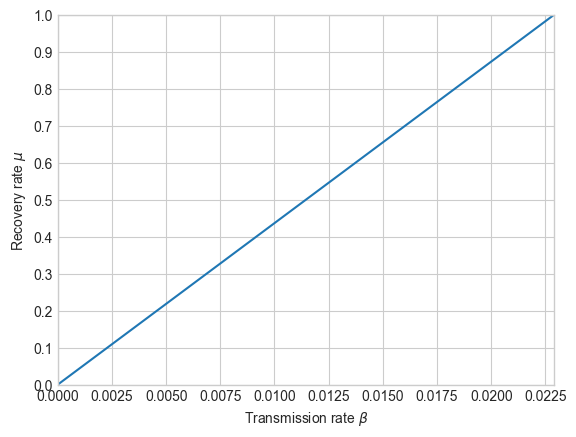

In [30]:
betas = np.linspace(0, 1 / degrees.mean(), 100)
mus = betas * degrees.mean()

plt.plot(betas, mus)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator())
ax.yaxis.set_major_locator(MaxNLocator())
plt.xlim(0, max(betas))
plt.ylim(0, max(mus))
plt.xlabel('Transmission rate $\\beta$')
plt.ylabel('Recovery rate $\\mu$');

The epidemic model simulated is SIS. It is implemented using a set to track the infected population at each step.

In [31]:
def node_will_be_infected(beta, mu, infected, node):
    if node in infected:
        return random.random() >= mu
    else:
        for neighbor in G.neighbors(node):
            if neighbor in infected and random.random() < beta:
                return True
        return False

def sis_step(beta, mu, infected):
    return {
        node for node in G.nodes
        if node_will_be_infected(beta, mu, infected, node)
    }

def sis_run(beta, mu, infected, steps):
    states = [infected]
    for _ in range(steps):
        states.append(sis_step(beta, mu, states[-1]))
    return SISResult(beta, mu, states)


@dataclass
class SISResult:
    beta: float
    mu: float
    states: list[set[int]]

    @cached_property
    def infected(self):
        return np.array([len(s) / len(G) for s in self.states])
    
    def plot_infected(infected, **kwargs):
        plt.gcf().set_figwidth(10)
        plt.gcf().set_figheight(8)
        plt.xlabel("Time step")
        plt.ylabel("Infected population")
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

        return plt.plot(range(len(infected)), infected, **kwargs)

The simulation is run 5 times, picking a random node to start the epidemic each time. Then the simulation is run for other two times, but starting the epidemic from the node with the highest degree. 

The parameters $\mu$ and $\beta$ were chosen to be close to the threshold, so that the disease may have a chance to either spread out or die out, depending on its starting point and its luck.

Seed: 9149037209531953671


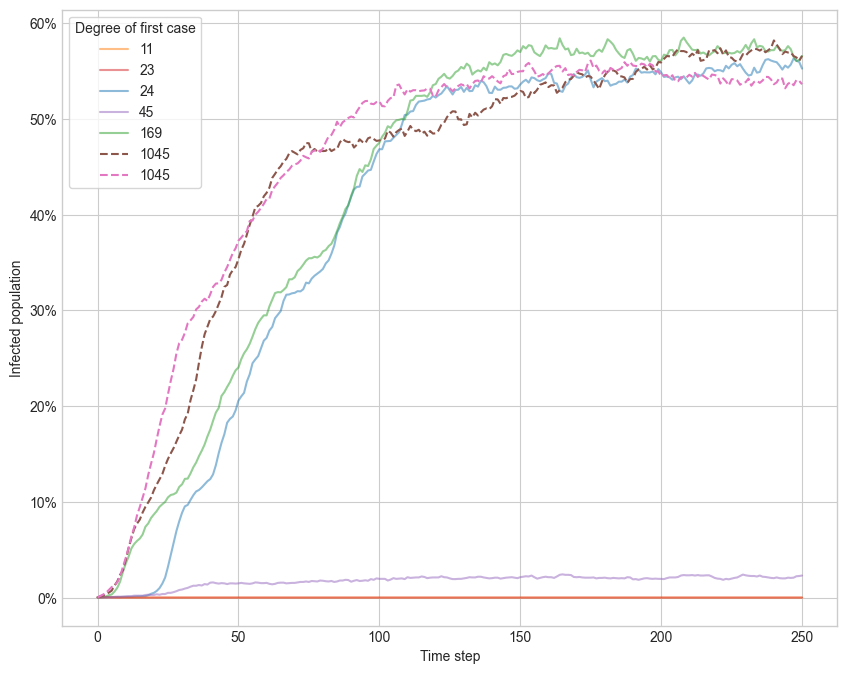

In [32]:
# seed(2832308665679531175)
seed(9149037209531953671)

beta = 0.005
mu = 0.05
steps = 250

for _ in range(5):
    first_case = random.choice(list(G.nodes)) 
    sis_run(beta, mu, [first_case], steps).plot_infected(
        label=degrees[first_case],
        alpha=0.5
    )

first_case = degrees.idxmax()
for _ in range(2):
    sis_run(beta, mu, [first_case], steps).plot_infected(
        label=degrees[first_case],
        linestyle='--'
    )

handles, _ = plt.gca().get_legend_handles_labels()
handles.sort(key=lambda h: int(h.get_label()))
plt.legend(title="Degree of first case", frameon=True, handles=handles);

The degree of the node from which the epidemic started is shown in the legend, so that the connection between node degree and spread time can be observed. The two nodes with the lowest degrees failed to spread the epidemic, and their lines lay at the bottom of the chart. As the degree of the first case increases, it has more chances to infect a neighbor, and it is more likely to become endemic.

Starting the epidemic from the most central node has lead to the contagion spreading consistently faster than starting at a random node.

Next, the simulation is run using 16 starting points. Using the communities found by the Louvain algorithm, for 5 simulations, the starting points are picked at random from the same community. For other 5, each starting point is picked from a distinct community.

Seed: 3961516525471418270


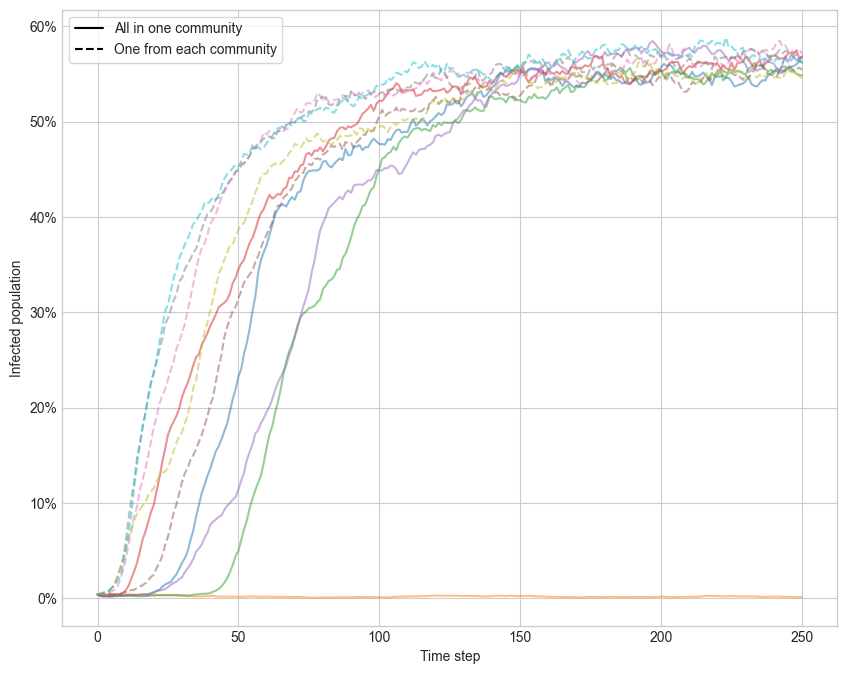

In [33]:
seed(3961516525471418270)

communities = [list(nodes) for nodes in louvain]

for _ in range(5):
    random_community = random.choice(communities)
    all_in_one = random.choices(random_community, k=len(communities))
    sis_run(beta, mu, all_in_one, steps).plot_infected(
        alpha=0.5,
    )

for _ in range(5):
    one_for_each = [random.choice(community) for community in communities]
    sis_run(beta, mu, one_for_each, steps).plot_infected(
        alpha=0.5,
        linestyle='--'
    )


handles = [
    Line2D([0], [0], label='All in one community', color='black'),
    Line2D([0], [0], label='One from each community', color='black', linestyle='--')
]
plt.legend(frameon=True, handles=handles);

As it can be seen in the graph, generally, starting from different communities leads to a faster and more successful spread. Some hypotheses on why might be that having the starting point starting from a single community might cause having the outbreak contained in the community itself, since there are fewer edges leading outside of the community then there are to nodes inside. Also, having starting points split in more communities might help in a degree-assortative network, since highly connected nodes might tend to form a cluster and in this way it is guaranteed to have a starting point in a cluster of high-degree nodes.
There is also the fact that having the start of the spread concentrated in a single community increases the probability of an infected node encountering another already infected one, giving it less chances at infecting an healthy one.